In [21]:
from initialization import Location
from initialization import Grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base Model

In [22]:

# Parameters
beta = 0.3 
mu = 0.1
population = 1000 
initial_infected = 1  
initial_susceptible = population - initial_infected  
initial_recovered = 0 
days = 100  

# Create arrays to store the results
susceptible = np.zeros(days)
infectious = np.zeros(days)
recovered = np.zeros(days)

# Initialize the initial conditions
susceptible[0] = initial_susceptible
infectious[0] = initial_infected
recovered[0] = initial_recovered

# Simulate the SIR model
for day in range(1, days):
    new_infections = beta * susceptible[day - 1] * infectious[day - 1] / population
    new_recoveries = mu * infectious[day - 1]

    susceptible[day] = susceptible[day - 1] - new_infections
    infectious[day] = infectious[day - 1] + new_infections - new_recoveries
    recovered[day] = recovered[day - 1] + new_recoveries



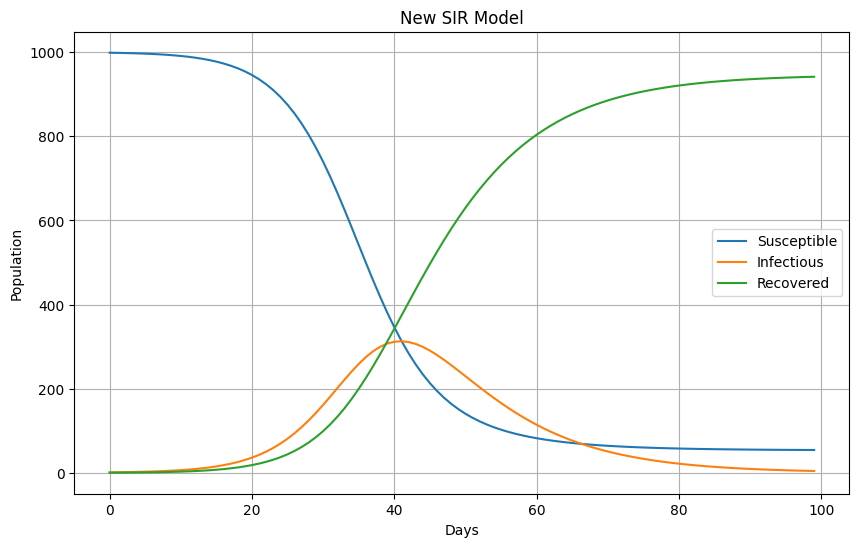

In [23]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(susceptible, label="Susceptible")
plt.plot(infectious, label="Infectious")
plt.plot(recovered, label="Recovered")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.title("New SIR Model")
plt.grid(True)
plt.show()

In [24]:

def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

# Mobility Based SIR Model w/ Dynamic Social and Outside Connectivity

In [25]:
from initialization import Location
from initialization import Grid
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def dynamic_alpha_connectivity(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials, outside_connectivity):
    # Parameters
    beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
    mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
    N = 100000
    n_locations=100
    days = 100
    alpha_range = np.arange(0,1.05,0.05)
    outside_connectivity = np.arange(0,1.05,0.05)
    trials=1

    alpha_connectivity_sir = {}
    for alpha in alpha_range:
        for c in outside_connectivity:
            for trial in range(trials):
                alpha_connectivity_sir[(alpha,c)] = []
                # Create arrays to store the results
                infectious = np.zeros(days)
                #Initialize grid and locations
                grid = Grid(n_locations, N, alpha, beta, mu, c)

                # Initialize random starting location based on chosen Mobility Type
                if type == "Random":
                    grid.random_orgin()
                elif type == "High Mobility":
                    grid.mobility_based_origin(threshold, True)
                else:
                    grid.mobility_based_origin(threshold, False)

                day = 0
                for day in range(days):
                    for loc in grid.map:
                        if loc.n != 0:
                            infections, total_connections = get_other_loc_params(grid, loc)
                            
                            new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                            
                            new_recoveries = (mu * loc.i) / loc.n

                            loc.s = loc.s - new_infections
                            loc.i = loc.i + new_infections - new_recoveries
                            loc.r = loc.r + new_recoveries

                            infectious[day] += loc.i
                    if infectious[day] < infectious[day-1] and day > 0:
                        alpha_connectivity_sir[(alpha,c)].append(day-1)
                        break
                if len(alpha_connectivity_sir[(alpha,c)]) == 0:
                    alpha_connectivity_sir[(alpha,c)].append(day)

            alpha_connectivity_sir[(alpha,c)] = np.mean(alpha_connectivity_sir[(alpha,c)])

    return alpha_connectivity_sir
    

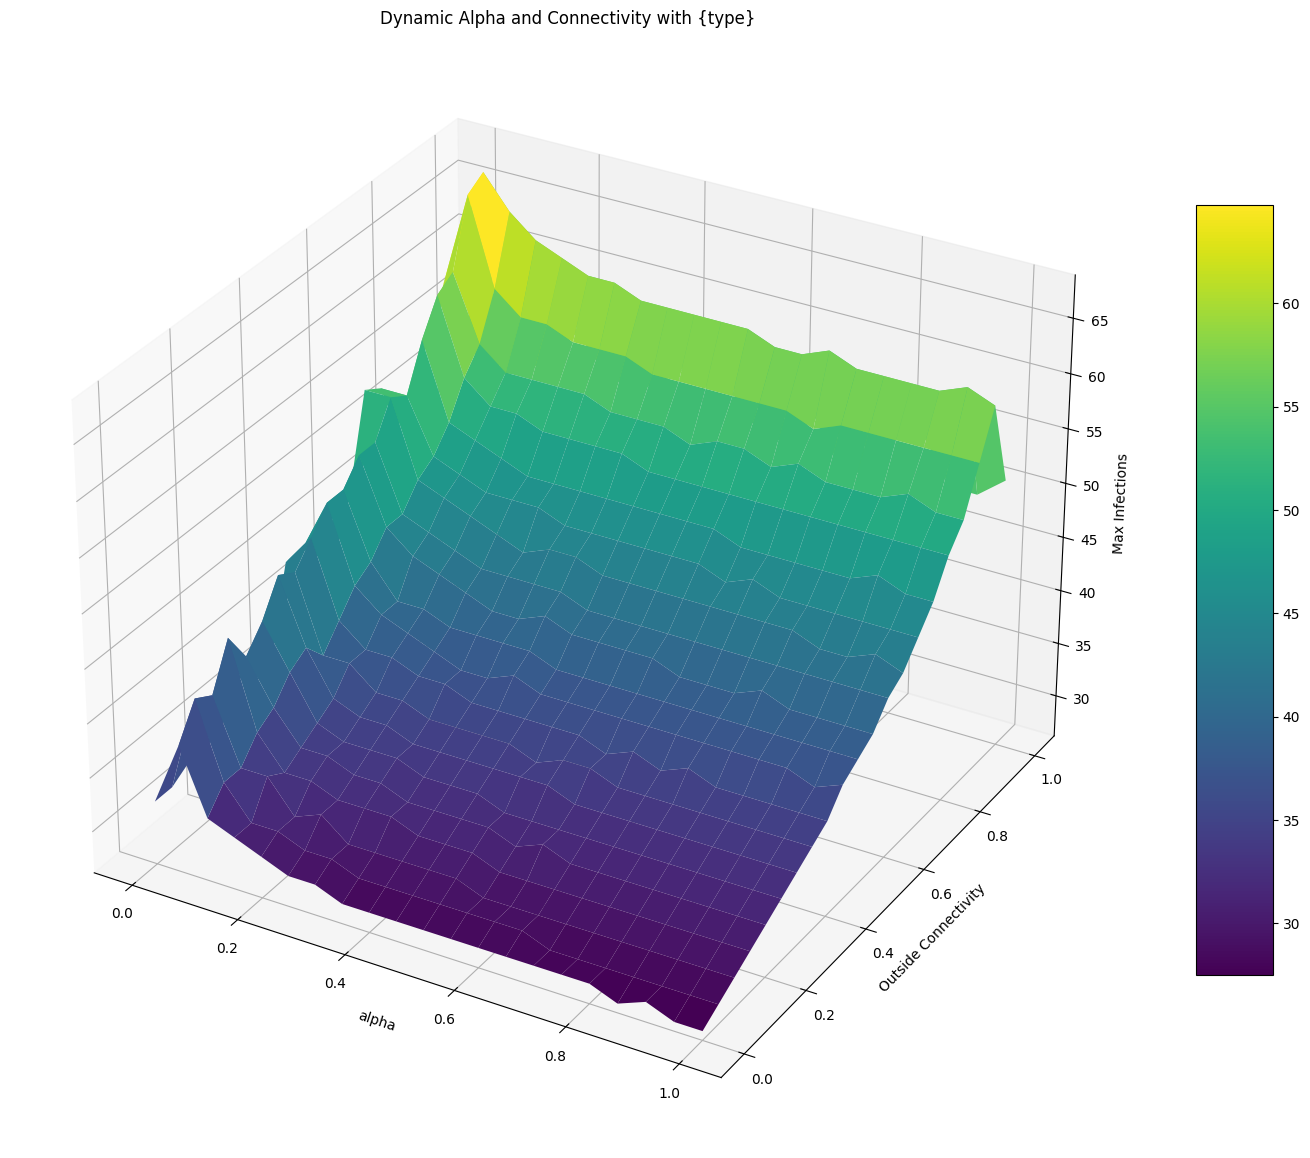

In [35]:
x = np.arange(0,1.05,0.05)
y = np.arange(0,1.05,0.05)[::-1]
x, y = np.meshgrid(x, y)

# Parameters
beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
N = 100000
n_locations=100
days = 100
alpha_range = np.arange(0,1.05,0.05)
outside_connectivity = np.arange(0,1.05,0.05)
trials=1
type = "High Mobility"
threshold = 0.1
dictionary = dynamic_alpha_connectivity(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials, outside_connectivity)


values = list(dictionary.values())
z = []

for i in range(len(np.arange(0,1.05,0.05))):
    miniList = []
    for j in range(len(np.arange(0,1.05,0.05))):
        miniList.append(values.pop(0))
    z.append(miniList)
z = np.array(z)

fig = plt.figure(figsize = (18, 20))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z, cmap='viridis')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('alpha')
ax.set_ylabel('Outside Connectivity')
ax.set_zlabel('Max Infections')
ax.set_title("Dynamic Alpha and Connectivity with {type}")

plt.show()

In [27]:
# def dynamic_alpha():
#     # Parameters
#     beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
#     mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
#     N = 100000
#     n_locations=100
#     days = 100
#     alphas = np.arange(0.1,1.1,0.1)
#     alpha=0.5
#     trials=10

#     alpha_sir = {}
#     for alpha in alphas:

#         # Create arrays to store the results
#         susceptible = np.zeros(days)
#         infectious = np.zeros(days)
#         recovered = np.zeros(days) 
#         for trial in range(trials):
    
#             #Initialize grid and locations
#             grid = Grid(n_locations, N, alpha, beta, mu)

#             #initialize random starting location
#             grid.random_orgin()

#             for day in range(days):
#                 for loc in grid.map:
#                     if loc.n != 0:
#                         infections, total_connections = get_other_loc_params(grid, loc)
                        
#                         new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
#                         new_recoveries = (mu * loc.i) / loc.n

#                         loc.s = loc.s - new_infections
#                         loc.i = loc.i + new_infections - new_recoveries
#                         loc.r = loc.r + new_recoveries

#                         susceptible[day] += loc.s
#                         infectious[day] += loc.i
#                         recovered[day] += loc.r

#         susceptible = [day / (trials*N) for day in susceptible]
#         infectious = [day / (trials*N) for day in infectious]
#         recovered = [day / (trials*N) for day in recovered]

#         susceptible.insert(0,1)
#         infectious.insert(0,1/N)
#         recovered.insert(0,0)

#         alpha_sir[alpha] = [susceptible, infectious, recovered]
#     return alpha_sir

In [28]:
# dynamic_alpha_results = dynamic_alpha()
# dynamic_alpha_results

In [29]:
# translation = {0:"S", 1:"I", 2:"R"}
# for key, values in dynamic_alpha_results.items():
#     plt.figure()
#     for sublist in values:
#         # plt.plot(sublist, label=f'{key}_{values.index(sublist)}')
#         plt.plot(sublist, label=translation[values.index(sublist)])
#         plt.title(f'SIR Model w/ alpha={key}')

#     plt.legend()
#     plt.xlabel("Generations")
#     plt.ylabel("Population Density")
    
# plt.show()

# Mobility Based SIR Models - Random, High, and Low

In [30]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials, c):
    alpha_sir = {}
    for alpha in alpha_range:

        # Create arrays to store the results
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu, c)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High Mobility":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)
                

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)
                        
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                        new_recoveries = (mu * loc.i) / loc.n

                        loc.s = loc.s - new_infections
                        loc.i = loc.i + new_infections - new_recoveries
                        loc.r = loc.r + new_recoveries

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r

        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered]
    return alpha_sir

In [31]:
def sir_plotting(results, type):
    translation = {0:"S", 1:"I", 2:"R"}
    for key, values in results:
        plt.figure()
        for sublist in values:
            # plt.plot(sublist, label=f'{key}_{values.index(sublist)}')
            plt.plot(sublist, label=translation[values.index(sublist)])
            plt.title(f'SIR Model w/ {type} Mobility: Alpha = {key}')

        plt.legend()
        plt.xlabel("Generations")
        plt.ylabel("Population Density")
    plt.show()

### SIR Model with Random Origin and Dynamic Alpha

In [ ]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
N = 1000 
n_locations=10
days = 100
alphas = np.arange(0.1,1.1,0.1)
trials=10
c = 0
type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, c)
sir_plotting(dynamic_alpha_results.items(), type)


### SIR Model with High Mobility and Dynamic Alpha

In [ ]:
type = "High"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, c)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results.items(), type)


### SIR Model with Low Mobility and Dynamic Alpha

In [ ]:
type = "Low"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, c)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results.items(), type)